In [1]:
import sys
import os
from pathlib import Path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from data.data_loader import DataLoader
import data.indicators as Indicators
import numpy as np
import pandas as pd

parent_dir = Path().resolve().parent
models_dir = parent_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True)

dfmain = DataLoader.load_data()
df = dfmain.copy()
len(df)
# Convert 'datetime' column to proper datetime format
df["datetime"] = pd.to_datetime(df["datetime"])

# Create 'seconds' column (Unix timestamp)
df["seconds"] = df["datetime"].map(pd.Timestamp.timestamp)

print(df)

        Unnamed: 0            datetime     open     high      low    close  \
0                0 2019-12-01 00:00:00   151.38   151.38   150.91   150.99   
1                1 2019-12-01 00:05:00   150.99   150.99   150.59   150.65   
2                2 2019-12-01 00:10:00   150.63   150.64   150.09   150.41   
3                3 2019-12-01 00:15:00   150.50   150.74   150.20   150.24   
4                4 2019-12-01 00:20:00   150.26   150.53   150.24   150.53   
...            ...                 ...      ...      ...      ...      ...   
429692      429692 2023-12-31 23:40:00  2281.22  2281.80  2280.64  2281.79   
429693      429693 2023-12-31 23:45:00  2281.79  2285.90  2281.03  2285.23   
429694      429694 2023-12-31 23:50:00  2285.23  2285.23  2282.11  2282.12   
429695      429695 2023-12-31 23:55:00  2282.11  2284.47  2281.34  2283.85   
429696      429696 2024-01-01 00:00:00  2283.84  2289.92  2282.97  2289.92   

          volume        date       seconds     EMA_slow  ...  I

In [2]:
def generate_perfect_signals(df, lookahead):
    df = df.copy()
    df['signals'] = np.nan  # Initialize with NaN for proper trend marking

    for i in range(len(df) - lookahead):
        future_prices = df['close'].iloc[i+1 : i+1+lookahead].values
        if len(future_prices) > 0:
            max_future_price = np.max(future_prices)
            min_future_price = np.min(future_prices)

            # If the price is near the lowest future price, mark an uptrend (1)
            if df['close'].iloc[i] <= min_future_price + 0.1:
                df.at[i, 'signals'] = 1  # Uptrend

            # If the price is near the highest future price, mark a downtrend (0)
            elif df['close'].iloc[i] >= max_future_price - 0.1:
                df.at[i, 'signals'] = 0  # Downtrend

    # **Propagate the trend signals forward**
    df['signals'] = df['signals'].ffill().fillna(0)  # Fill NaN values with previous trend, default to 0
    
    return df

df = generate_perfect_signals(dfmain,20)
print(df['signals'])

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
429692    0.0
429693    0.0
429694    0.0
429695    0.0
429696    0.0
Name: signals, Length: 429697, dtype: float64


## Data Processing

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
features = [
        "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
        "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
        "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", "open", "high", "low", "close", "seconds"
    ]
df_as_np = df[features].to_numpy()

def preprocess_data(df, window_size):
    df.dropna(inplace=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    df[features] = scaler.fit_transform(df[features])

    # Convert into time-series sequences (shape: [samples, timesteps, features])
    X, y = [], []
    '''
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)  # Past N timesteps
        y.append(df[features].iloc[i+window_size].values)  # Future values for all features
    
    '''
    df_as_np = df[features].to_numpy()
    for i in range(len(df_as_np) - window_size):
        row = df_as_np[i:i+window_size]  # This keeps shape (60, 46)
        X.append(row)
        y.append(df_as_np[i+window_size])  # Target at t+window_size

    return np.array(X), np.array(y), df, scaler  # Return scaler for inverse transform

# Preprocess the data
X, y, processed_df, scaler = preprocess_data(df, window_size=60)
print(X.shape) 
print(y.shape)
# Save the processed dataframe to a CSV file
processed_df.to_csv("processed_data.csv", index=False)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


(429414, 60, 22)
(429414, 22)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # For progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=17, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])  # Take only the last timestep output
        return x

# Instantiate model
input_size = X_train.shape[2]  # Number of features
output_size = y_train.shape[1]  # Number of target variables
model = LSTMModel(input_size, output_size=output_size).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop with progress bar
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), "LSTM_FNN_LSTM_model.pth")
print("✅ Model saved as 'LSTM_FNN_LSTM_model.pth'")


🔥 Using device: cuda


Epoch 1/20: 100%|██████████| 10736/10736 [00:56<00:00, 191.38batch/s, loss=0.0009]


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.40 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 3.90 GiB is allocated by PyTorch, and 28.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

🔹 Test MSE: 0.000916
🔹 Test MAE: 0.020562
🔹 R² Score: 0.8554


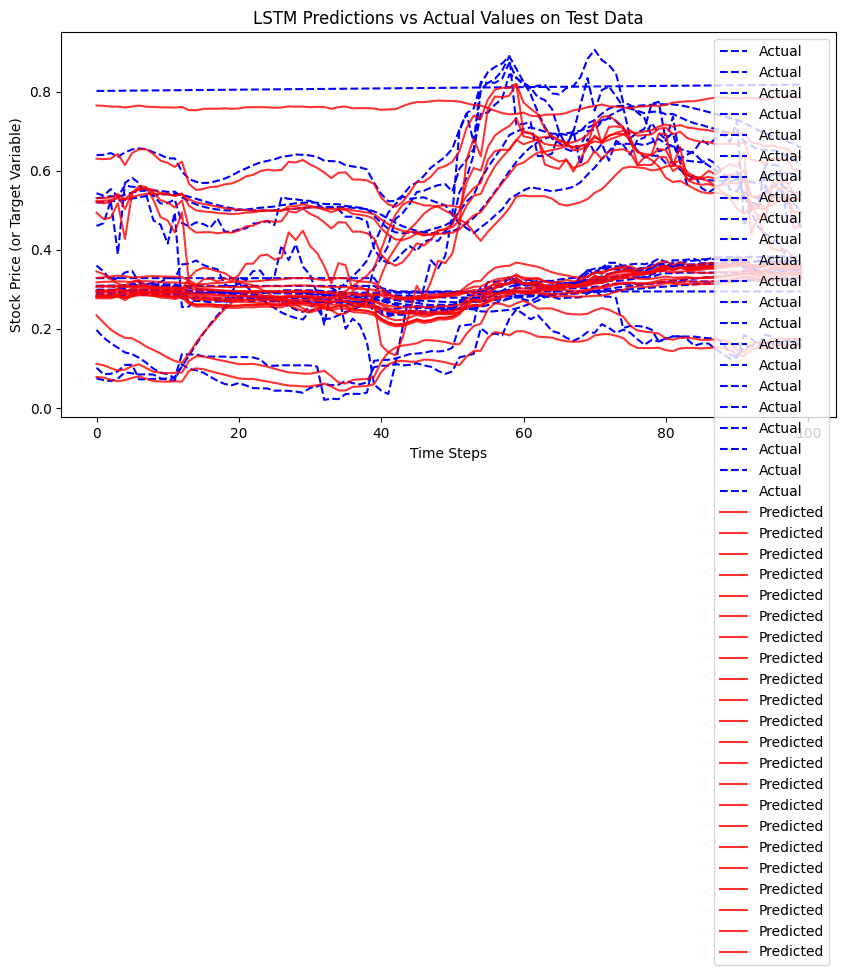

In [38]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure model is in evaluation mode (disables dropout & batch norm)
model.eval()

# Move X_test to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Disable gradient calculations for inference
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Move predictions to CPU
y_pred_numpy = y_pred_tensor.cpu().numpy()

# ✅ Fix: y_test is already NumPy, so no .cpu() needed
y_test_numpy = y_test  # No need for .cpu().numpy()

# 🔹 Compute Evaluation Metrics
mse = mean_squared_error(y_test_numpy, y_pred_numpy)
mae = mean_absolute_error(y_test_numpy, y_pred_numpy)
r2 = r2_score(y_test_numpy, y_pred_numpy)

# Print metrics
print(f"🔹 Test MSE: {mse:.6f}")
print(f"🔹 Test MAE: {mae:.6f}")
print(f"🔹 R² Score: {r2:.4f}")

# 🔹 Plot Actual vs Predicted (First 100 Samples)
plt.figure(figsize=(10, 5))
plt.plot(y_test_numpy[:100], label="Actual", linestyle="dashed", color="blue")
plt.plot(y_pred_numpy[:100], label="Predicted", alpha=0.8, color="red")
plt.legend()
plt.title("LSTM Predictions vs Actual Values on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (or Target Variable)")
plt.show()


### Hyper tuning

In [40]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define LSTM Model
def create_lstm_model(input_dim, hidden_dim, num_layers, dropout, output_dim):
    class LSTMModel(nn.Module):
        def __init__(self):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            return self.fc(lstm_out[:, -1, :])  # Take the last time step output
    
    return LSTMModel()

# Objective function for Optuna
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    
    model = create_lstm_model(input_dim=X_train.shape[2], hidden_dim=hidden_dim,
                              num_layers=num_layers, dropout=dropout, output_dim=y_train.shape[1])
    model.to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    model.train()
    for epoch in range(10):  # Small epochs for tuning
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    return loss.item()

# Run Optuna study
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Run 20 trials

# Best hyperparameters
print("Best hyperparameters:", study.best_params)


e:\Python\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-08 18:46:39,781] A new study created in memory with name: no-name-309f1f9f-9b25-4a46-be7a-76085dee80f0
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6984\3038151413.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
e:\Python\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
[I 2025-03-08 18:46:42,761] Trial 0 finished wit

Best hyperparameters: {'hidden_dim': 192, 'num_layers': 2, 'dropout': 0.5, 'batch_size': 16, 'learning_rate': 0.0005839081038527126}


## Model with the parameters that came out of the previous testing

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # For progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Define Optimized LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim=192, num_layers=2, output_size=17, dropout_prob=0.5):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers=num_layers, dropout=dropout_prob, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take only the last timestep output
        return x

# Instantiate model with optimized hyperparameters
input_size = X_train.shape[2]  # Number of features
output_size = y_train.shape[1]  # Number of target variables
model = LSTMModel(input_size, output_size=output_size).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005839081038527126)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
batch_size = 16  # Optimized batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop with progress bar
epochs = 10  # Adjust epochs based on early stopping
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), "Best_LSTM_model.pth")
print("✅ Best model saved as 'Best_LSTM_model.pth'")


🔥 Using device: cuda


Epoch 1/10: 100%|██████████| 308/308 [00:04<00:00, 66.65batch/s, loss=0.0041]


✅ Epoch [1/10], Loss: 0.0137, Val Loss: 0.0049


Epoch 2/10: 100%|██████████| 308/308 [00:04<00:00, 69.48batch/s, loss=0.0015]


✅ Epoch [2/10], Loss: 0.0029, Val Loss: 0.0019


Epoch 3/10: 100%|██████████| 308/308 [00:04<00:00, 68.14batch/s, loss=0.0025]


✅ Epoch [3/10], Loss: 0.0020, Val Loss: 0.0017


Epoch 4/10: 100%|██████████| 308/308 [00:04<00:00, 69.59batch/s, loss=0.0014]


✅ Epoch [4/10], Loss: 0.0016, Val Loss: 0.0017


Epoch 5/10: 100%|██████████| 308/308 [00:04<00:00, 68.57batch/s, loss=0.0012]


✅ Epoch [5/10], Loss: 0.0014, Val Loss: 0.0013


Epoch 6/10: 100%|██████████| 308/308 [00:04<00:00, 68.44batch/s, loss=0.0008]


✅ Epoch [6/10], Loss: 0.0012, Val Loss: 0.0019


Epoch 7/10: 100%|██████████| 308/308 [00:04<00:00, 67.95batch/s, loss=0.0004]


✅ Epoch [7/10], Loss: 0.0011, Val Loss: 0.0015


Epoch 8/10: 100%|██████████| 308/308 [00:04<00:00, 69.14batch/s, loss=0.0010]


✅ Epoch [8/10], Loss: 0.0010, Val Loss: 0.0010


Epoch 9/10: 100%|██████████| 308/308 [00:04<00:00, 69.59batch/s, loss=0.0008]


✅ Epoch [9/10], Loss: 0.0010, Val Loss: 0.0009


Epoch 10/10: 100%|██████████| 308/308 [00:04<00:00, 69.85batch/s, loss=0.0003]


✅ Epoch [10/10], Loss: 0.0009, Val Loss: 0.0010
✅ Best model saved as 'Best_LSTM_model.pth'


🔹 Test MSE: 0.001036
🔹 Test MAE: 0.024181
🔹 R² Score: 0.8627


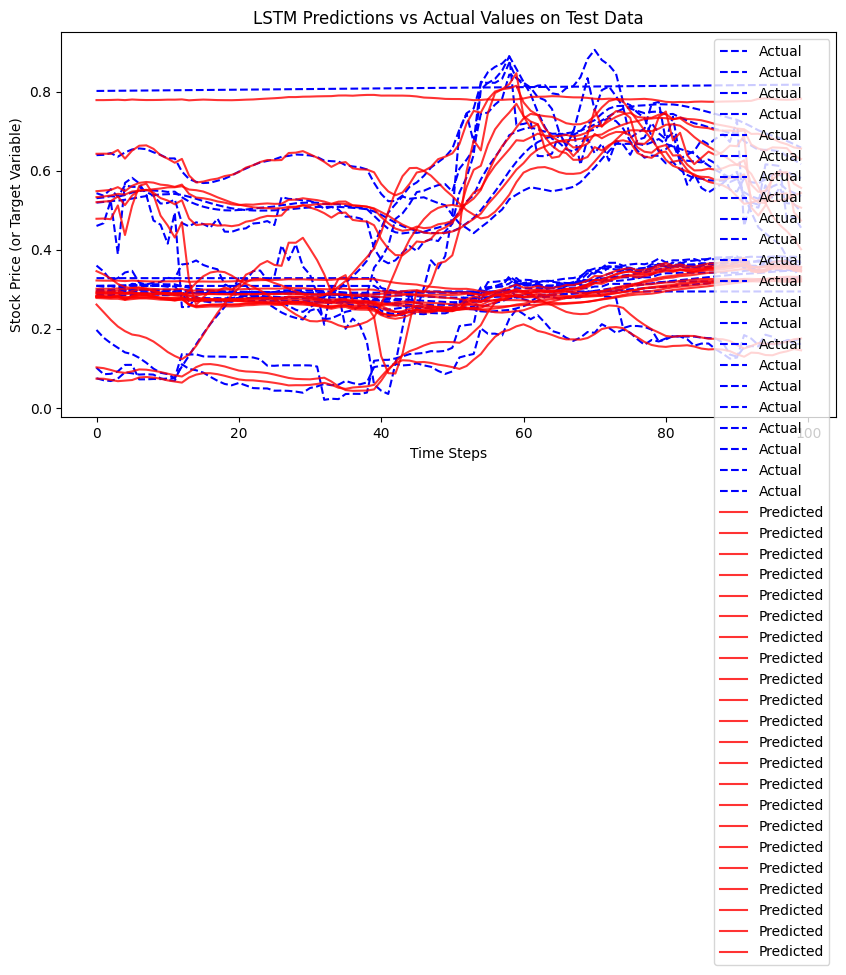

In [8]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure model is in evaluation mode (disables dropout & batch norm)
model.eval()

# Move X_test to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Disable gradient calculations for inference
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Move predictions to CPU
y_pred_numpy = y_pred_tensor.cpu().numpy()

# ✅ Fix: y_test is already NumPy, so no .cpu() needed
y_test_numpy = y_test  # No need for .cpu().numpy()

# 🔹 Compute Evaluation Metrics
mse = mean_squared_error(y_test_numpy, y_pred_numpy)
mae = mean_absolute_error(y_test_numpy, y_pred_numpy)
r2 = r2_score(y_test_numpy, y_pred_numpy)

# Print metrics
print(f"🔹 Test MSE: {mse:.6f}")
print(f"🔹 Test MAE: {mae:.6f}")
print(f"🔹 R² Score: {r2:.4f}")

# 🔹 Plot Actual vs Predicted (First 100 Samples)
plt.figure(figsize=(10, 5))
plt.plot(y_test_numpy[:100], label="Actual", linestyle="dashed", color="blue")
plt.plot(y_pred_numpy[:100], label="Predicted", alpha=0.8, color="red")
plt.legend()
plt.title("LSTM Predictions vs Actual Values on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (or Target Variable)")
plt.show()


# Feedforward Neural Network (FNN)

### Create the Y because X is already there

In [15]:
from sklearn.model_selection import train_test_split
features = [
        "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
        "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
        "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", "open", "high", "low", "close", "seconds"
    ]
df_as_np = df[features].to_numpy()
# Define features (X) and target (y)
X = df_as_np  # Convert feature columns to NumPy array
y_signals = df["signals"].to_numpy()  # Convert target column to NumPy array

print("X shape:", X.shape)
print("y shape:", y_signals.shape)

# Train-test split (80% train, 20% test), preserving time series order
X_train, X_test, signals_train, signals_test = train_test_split(X, y_signals, test_size=0.2, random_state=42, shuffle=False)

print("X_train shape:", X_train.shape)
print("y_train shape:", signals_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", signals_test.shape)

import numpy as np

print("Uptrend (1) Count:", np.sum(y == 1))
print("Downtrend (0) Count:", np.sum(y == 0))


X shape: (6204, 22)
y shape: (6204,)
X_train shape: (4963, 22)
y_train shape: (4963,)
X_test shape: (1241, 22)
y_test shape: (1241,)
Uptrend (1) Count: 3230
Downtrend (0) Count: 2974


In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm  # Progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Features and Target
features = [
    "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
    "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
    "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", 
    "open", "high", "low", "close", "seconds"
]
X = df[features].values
y = df["signals"].values  # Target (1 = Uptrend, 0 = Downtrend)

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% train, 20% test, shuffled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Make it 2D
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)  # Make it 2D

# Compute Class Weights (Handles Imbalance)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define Larger Feedforward Neural Network
class LargeFeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(LargeFeedForwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)  # No Sigmoid (Handled by BCEWithLogitsLoss)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
input_size = len(features)  # 22 features
model = LargeFeedForwardNN(input_size).to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Handles class imbalance
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Lowered LR for smoother training

# Create DataLoader for mini-batch training
batch_size = 64  # Increased batch size for stability
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
epochs = 30  # Increased epochs for more training
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_logits = model(X_test_tensor)
        val_loss = criterion(val_logits, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), "LARGE_FNN_price_trend_model.pth")
print("✅ Model saved as 'LARGE_FNN_price_trend_model.pth'")

# Function to Predict Market Trend
def predict_trend(model, X_new):
    model.eval()
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_new_tensor)
        probabilities = torch.sigmoid(logits)  # Convert logits to probabilities
        predictions = (probabilities > 0.5).int()  # Convert to binary (0 or 1)
    return predictions.cpu().numpy()

# Example usage
predictions = predict_trend(model, X_test)
print("Sample Predictions:", predictions[:100])
print("Sample Actual Labels:", y_test[:100])

🔥 Using device: cuda


Epoch 1/30: 100%|██████████| 78/78 [00:00<00:00, 134.60batch/s, loss=0.6278]


✅ Epoch [1/30], Loss: 0.6033, Val Loss: 0.5815


Epoch 2/30: 100%|██████████| 78/78 [00:00<00:00, 162.49batch/s, loss=0.6867]


✅ Epoch [2/30], Loss: 0.5886, Val Loss: 0.5698


Epoch 3/30: 100%|██████████| 78/78 [00:00<00:00, 156.43batch/s, loss=0.5119]


✅ Epoch [3/30], Loss: 0.5758, Val Loss: 0.5798


Epoch 4/30: 100%|██████████| 78/78 [00:00<00:00, 168.38batch/s, loss=0.6568]


✅ Epoch [4/30], Loss: 0.5716, Val Loss: 0.5602


Epoch 5/30: 100%|██████████| 78/78 [00:00<00:00, 172.69batch/s, loss=0.6283]


✅ Epoch [5/30], Loss: 0.5697, Val Loss: 0.5490


Epoch 6/30: 100%|██████████| 78/78 [00:00<00:00, 161.42batch/s, loss=0.5104]


✅ Epoch [6/30], Loss: 0.5623, Val Loss: 0.5553


Epoch 7/30: 100%|██████████| 78/78 [00:00<00:00, 160.57batch/s, loss=0.5720]


✅ Epoch [7/30], Loss: 0.5607, Val Loss: 0.5472


Epoch 8/30: 100%|██████████| 78/78 [00:00<00:00, 150.15batch/s, loss=0.6051]


✅ Epoch [8/30], Loss: 0.5565, Val Loss: 0.5440


Epoch 9/30: 100%|██████████| 78/78 [00:00<00:00, 158.12batch/s, loss=0.5426]


✅ Epoch [9/30], Loss: 0.5565, Val Loss: 0.5384


Epoch 10/30: 100%|██████████| 78/78 [00:00<00:00, 167.95batch/s, loss=0.5528]


✅ Epoch [10/30], Loss: 0.5469, Val Loss: 0.5448


Epoch 11/30: 100%|██████████| 78/78 [00:00<00:00, 165.40batch/s, loss=0.4674]


✅ Epoch [11/30], Loss: 0.5531, Val Loss: 0.5314


Epoch 12/30: 100%|██████████| 78/78 [00:00<00:00, 166.69batch/s, loss=0.5626]


✅ Epoch [12/30], Loss: 0.5448, Val Loss: 0.5320


Epoch 13/30: 100%|██████████| 78/78 [00:00<00:00, 146.69batch/s, loss=0.4963]


✅ Epoch [13/30], Loss: 0.5408, Val Loss: 0.5192


Epoch 14/30: 100%|██████████| 78/78 [00:00<00:00, 172.79batch/s, loss=0.5987]


✅ Epoch [14/30], Loss: 0.5393, Val Loss: 0.5252


Epoch 15/30: 100%|██████████| 78/78 [00:00<00:00, 166.05batch/s, loss=0.5958]


✅ Epoch [15/30], Loss: 0.5374, Val Loss: 0.5103


Epoch 16/30: 100%|██████████| 78/78 [00:00<00:00, 167.14batch/s, loss=0.5439]


✅ Epoch [16/30], Loss: 0.5383, Val Loss: 0.5084


Epoch 17/30: 100%|██████████| 78/78 [00:00<00:00, 161.23batch/s, loss=0.5121]


✅ Epoch [17/30], Loss: 0.5272, Val Loss: 0.5083


Epoch 18/30: 100%|██████████| 78/78 [00:00<00:00, 153.44batch/s, loss=0.4306]


✅ Epoch [18/30], Loss: 0.5343, Val Loss: 0.5127


Epoch 19/30: 100%|██████████| 78/78 [00:00<00:00, 166.44batch/s, loss=0.4592]


✅ Epoch [19/30], Loss: 0.5221, Val Loss: 0.5021


Epoch 20/30: 100%|██████████| 78/78 [00:00<00:00, 167.81batch/s, loss=0.3965]


✅ Epoch [20/30], Loss: 0.5224, Val Loss: 0.5034


Epoch 21/30: 100%|██████████| 78/78 [00:00<00:00, 167.55batch/s, loss=0.4240]


✅ Epoch [21/30], Loss: 0.5220, Val Loss: 0.4978


Epoch 22/30: 100%|██████████| 78/78 [00:00<00:00, 166.02batch/s, loss=0.6537]


✅ Epoch [22/30], Loss: 0.5195, Val Loss: 0.5065


Epoch 23/30: 100%|██████████| 78/78 [00:00<00:00, 166.85batch/s, loss=0.5362]


✅ Epoch [23/30], Loss: 0.5320, Val Loss: 0.5051


Epoch 24/30: 100%|██████████| 78/78 [00:00<00:00, 150.99batch/s, loss=0.4536]


✅ Epoch [24/30], Loss: 0.5144, Val Loss: 0.4913


Epoch 25/30: 100%|██████████| 78/78 [00:00<00:00, 166.52batch/s, loss=0.5424]


✅ Epoch [25/30], Loss: 0.5122, Val Loss: 0.5088


Epoch 26/30: 100%|██████████| 78/78 [00:00<00:00, 171.73batch/s, loss=0.6630]


✅ Epoch [26/30], Loss: 0.5200, Val Loss: 0.4935


Epoch 27/30: 100%|██████████| 78/78 [00:00<00:00, 163.16batch/s, loss=0.5472]


✅ Epoch [27/30], Loss: 0.5120, Val Loss: 0.5029


Epoch 28/30: 100%|██████████| 78/78 [00:00<00:00, 167.87batch/s, loss=0.5553]


✅ Epoch [28/30], Loss: 0.5169, Val Loss: 0.4952


Epoch 29/30: 100%|██████████| 78/78 [00:00<00:00, 150.68batch/s, loss=0.5687]


✅ Epoch [29/30], Loss: 0.5052, Val Loss: 0.4817


Epoch 30/30: 100%|██████████| 78/78 [00:00<00:00, 162.18batch/s, loss=0.4532]

✅ Epoch [30/30], Loss: 0.5000, Val Loss: 0.4838
✅ Model saved as 'LARGE_FNN_price_trend_model.pth'
Sample Predictions: [[1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]]
Sample Actual Labels: [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1.]


In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# ✅ Remove noisy features (e.g., 'seconds')
features = [
    "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
    "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
    "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", 
    "open", "high", "low", "close"
]

X = df[features].values
y = df["signals"].values  # Target (1 = Uptrend, 0 = Downtrend)

# ✅ Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# ✅ Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# ✅ Compute Class Weights (Better Balance)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# ✅ Use Swish Activation (Better than ReLU)
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# ✅ Better Feedforward Neural Network
class AdvancedFNN(nn.Module):
    def __init__(self, input_size):
        super(AdvancedFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            Swish(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            Swish(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            Swish(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            Swish(),
            nn.Dropout(0.1),

            nn.Linear(32, 1)  # No Sigmoid (Handled by BCEWithLogitsLoss)
        )

    def forward(self, x):
        return self.model(x)

# ✅ Instantiate model
input_size = len(features)
model = AdvancedFNN(input_size).to(device)

# ✅ Focal Loss (Better for Class Imbalance)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        focal_weight = self.alpha * (1 - probs) ** self.gamma
        return focal_weight * bce_loss

criterion = FocalLoss()

# ✅ Optimizer + Learning Rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

# ✅ Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Training loop with LR scheduling
epochs = 40  # More epochs for better learning
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y).mean()  # Ensure loss is a scalar
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # ✅ Validation
    model.eval()
    with torch.no_grad():
        val_logits = model(X_test_tensor)
        val_loss = criterion(val_logits, y_test_tensor)

    scheduler.step(val_loss.item())  # Convert tensor to scalar
    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# ✅ Save Model
torch.save(model.state_dict(), "AdvancedFNN_price_trend.pth")
print("✅ Model saved as 'AdvancedFNN_price_trend.pth'")

# ✅ Prediction Function
def predict_trend(model, X_new):
    model.eval()
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_new_tensor)
        probabilities = torch.sigmoid(logits)
        predictions = (probabilities > 0.5).int()
    return predictions.cpu().numpy()

# Example usage
predictions = predict_trend(model, X_test)
print("Sample Predictions:", predictions[:10])


e:\Python\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔥 Using device: cuda


Epoch 1/40: 100%|██████████| 78/78 [00:00<00:00, 128.93batch/s, loss=0.0198]


RuntimeError: a Tensor with 1241 elements cannot be converted to Scalar

# CPU Codes

In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Enable GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ Using GPU:", gpus[0])
    tf.config.experimental.set_memory_growth(gpus[0], True)  # Prevents memory overload
else:
    print("⚠️ No GPU detected, using CPU.")

def build_lstm_model(input_shape, output_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(output_shape, activation="linear"),  # Linear for regression
    ])
    
    model.compile(loss="mse", optimizer="adam")  # No need to add mse as metric (loss is already mse)
    return model

# Build the model
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_shape=y_train.shape[1])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,  # Reduced epochs
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1  # Show cleaner progress
)

# Save the model
model_path = models_dir / "LSTM_FNN_LSTM_model.h5"
model.save(str(model_path))


⚠️ No GPU detected, using CPU.
Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0780 - val_loss: 0.0079
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0150 - val_loss: 0.0049
Epoch 3/50
 81/154 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0103

KeyboardInterrupt: 